# Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

# Classification Model Development

Logistic Regression with clean data

In [3]:
data = pd.read_csv('grasp_data.csv')

# Split data into features and labels
X = data.drop('Grasp_quality', axis=1)
y = data['Grasp_quality']

# sclae the data
scaler = StandardScaler()
X_clean = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.8, random_state=42)

# Train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

model_noise = LogisticRegression(max_iter=1000)

# Predict on the test set
y_pred = model.predict(X_test)

# check the accuracy of the model
accuracy_lr = accuracy_score(y_test, y_pred)
recall_lr = recall_score(y_test, y_pred, average='weighted')
precision_lr = precision_score(y_test, y_pred, average='weighted')
f1_lr = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy: {accuracy_lr}', f'Recall: {recall_lr}', f'Precision: {precision_lr}', f'F1: {f1_lr}')

Accuracy: 0.7175 Recall: 0.7175 Precision: 0.7112343587069865 F1: 0.7118744588744589


Logistic Regression with noise

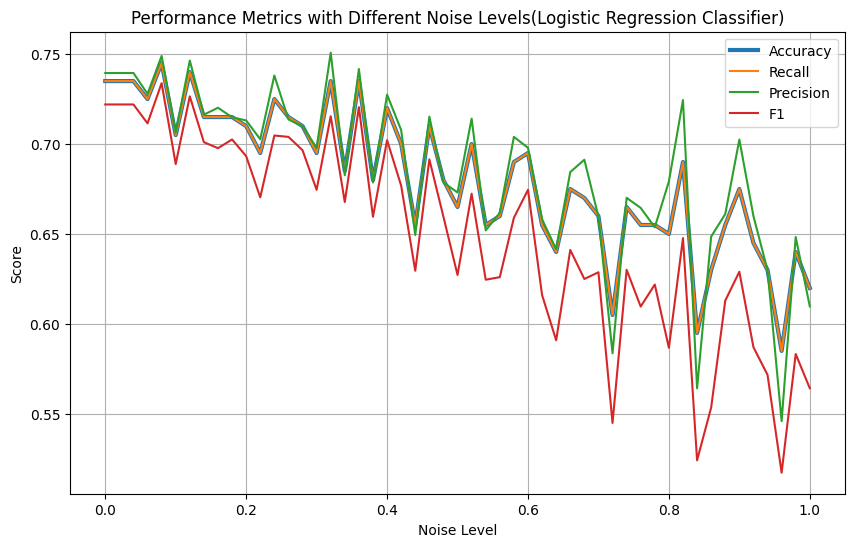

In [35]:
X_noise = X.copy()

# Calculate the average of each feature
Average = X.mean(axis=0)

# Initialize lists to store the results
noise_level = np.arange(0, 1.02, 0.02)
accuracy_lr = []
recall_lr = []
precision_lr = []
f1_lr = []

scaler = StandardScaler()

for i in noise_level:
    X_noise = X.copy()
    
    # for each feature, add gaussian noise according to the average of the feature
    for col in X_noise.columns:
        X_noise[col] = X_noise[col] + np.random.normal(0, i * abs(Average[col]), X_noise.shape[0])
        
    X_noise_scaled = scaler.fit_transform(X_noise)

    X_train_noise, X_test_noise, y_train_noise, y_test_noise = train_test_split(X_noise_scaled, y, test_size=0.4, random_state=42)

    model_noise = LogisticRegression(max_iter=1000, penalty='l1', solver='saga', C=0.1)
    model_noise.fit(X_train_noise, y_train_noise)

    y_pred_noise = model_noise.predict(X_test_noise)

    accuracy_noise = accuracy_score(y_test_noise, y_pred_noise)
    recall_noise = recall_score(y_test_noise, y_pred_noise, average='weighted')
    precision_noise = precision_score(y_test_noise, y_pred_noise, average='weighted')
    f1_noise = f1_score(y_test_noise, y_pred_noise, average='weighted')
    
    # Store the results
    accuracy_lr.append(accuracy_noise)
    recall_lr.append(recall_noise)
    precision_lr.append(precision_noise)
    f1_lr.append(f1_noise)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(noise_level, accuracy_lr, label='Accuracy', linewidth=3)
plt.plot(noise_level, recall_lr, label='Recall')
plt.plot(noise_level, precision_lr, label='Precision')
plt.plot(noise_level, f1_lr, label='F1')
plt.legend()
plt.xlabel('Noise Level')
plt.ylabel('Score')
plt.title('Performance Metrics with Different Noise Levels(Logistic Regression Classifier)')
plt.grid(True)
plt.show()



Accuracy: 0.7822222222222223 Recall: 0.7822222222222223 Precision: 0.7872060659469781 F1: 0.7839476828271396


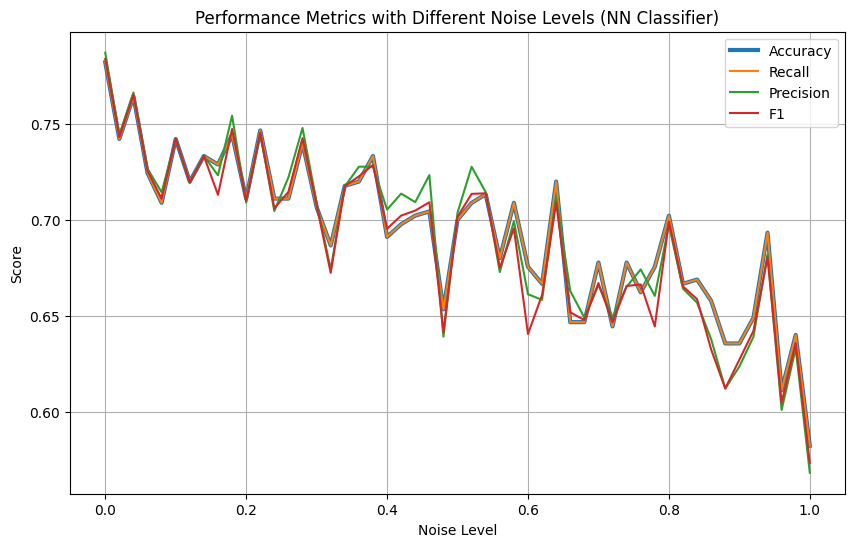

In [57]:
# Initialize lists to store the results
noise_level = np.arange(0, 1.02, 0.02)
accuracy_nn = []
recall_nn = []
precision_nn = []
f1_nn = []

scaler = StandardScaler()

# Define PyTorch Neural Network Model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return self.softmax(x)

for i in noise_level:
    # Add Gaussian noise to each feature
    X_noise = X.copy()  # Reset X_noise at each iteration
    for col in X_noise.columns:
        X_noise[col] = X_noise[col] + np.random.normal(0, i * abs(Average[col]), X_noise.shape[0])
    
    # Scale features
    X_noise_scaled = scaler.fit_transform(X_noise)
    
    # Split into train and test sets
    X_train_noise, X_test_noise, y_train_noise, y_test_noise = train_test_split(X_noise_scaled, y, test_size=0.9, random_state=42)
    
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_noise, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_noise.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test_noise, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_noise.values, dtype=torch.long)
    
    # Initialize NN Model
    input_size = X_train_noise.shape[1]
    hidden_size1 = 64  # Number of hidden neurons
    hidden_size2 = 32  # Number of hidden neurons
    output_size = len(np.unique(y))  # Number of classes
    model = NeuralNet(input_size, hidden_size1, hidden_size2, output_size)
    
    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training Loop
    epochs = 100
    for epoch in range(epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluate the Model
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor)
        y_pred_classes = torch.argmax(y_pred_test, axis=1).numpy()
    
    # Calculate metrics
    accuracy_nn.append(accuracy_score(y_test_noise, y_pred_classes))
    recall_nn.append(recall_score(y_test_noise, y_pred_classes, average='weighted'))
    precision_nn.append(precision_score(y_test_noise, y_pred_classes, average='weighted'))
    f1_nn.append(f1_score(y_test_noise, y_pred_classes, average='weighted'))

# print the results for noise = 0
print(f'Accuracy: {accuracy_nn[0]}', f'Recall: {recall_nn[0]}', f'Precision: {precision_nn[0]}', f'F1: {f1_nn[0]}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(noise_level, accuracy_nn, label='Accuracy', linewidth=3)
plt.plot(noise_level, recall_nn, label='Recall')
plt.plot(noise_level, precision_nn, label='Precision')
plt.plot(noise_level, f1_nn, label='F1')
plt.legend()
plt.xlabel('Noise Level')
plt.ylabel('Score')
plt.title('Performance Metrics with Different Noise Levels (NN Classifier)')
plt.grid(True)
plt.show()

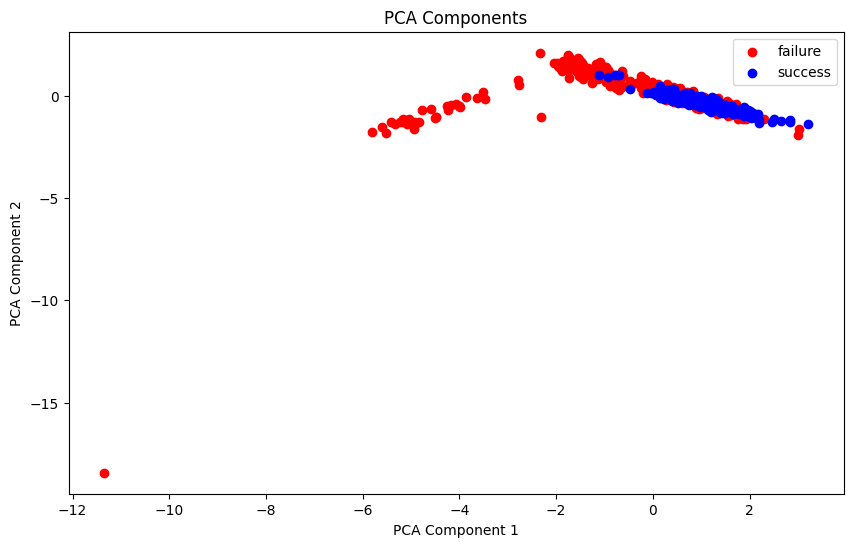

In [6]:
# perform PCA resduction on the data
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clean)

# Plot the data where red = 0 and blue = 1
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='red', label='failure')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='blue', label='success')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Components')
plt.legend()



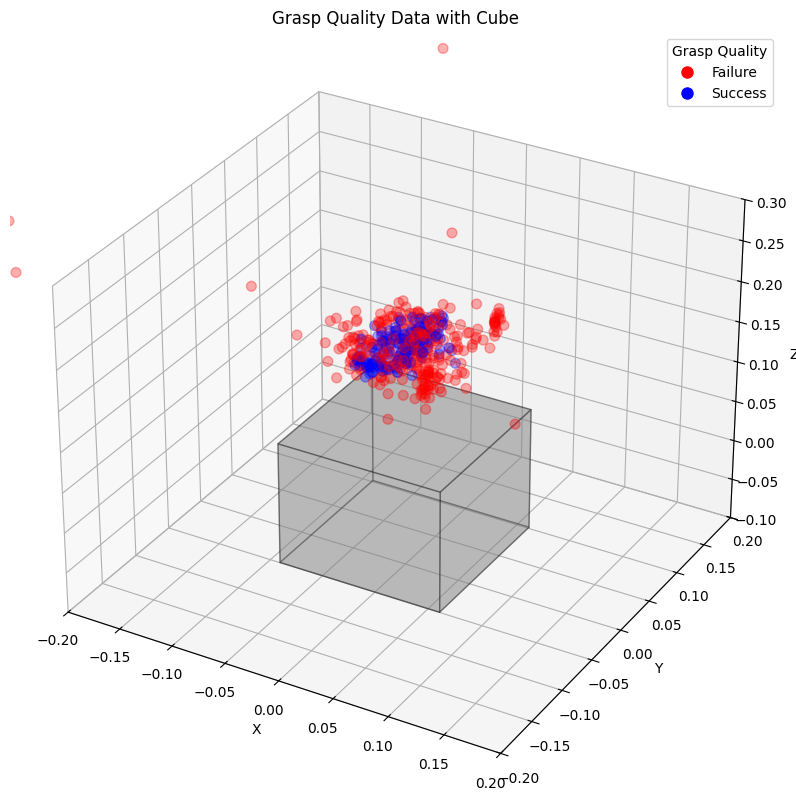

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Load the data
data = pd.read_csv('grasp_data.csv')

# Define the vertices of the cube
cube_length = 0.15
half_length = cube_length / 2

cube_vertices = [
    [-half_length, -half_length, -half_length],  # Bottom face
    [-half_length, half_length, -half_length],
    [half_length, half_length, -half_length],
    [half_length, -half_length, -half_length],
    [-half_length, -half_length, half_length],  # Top face
    [-half_length, half_length, half_length],
    [half_length, half_length, half_length],
    [half_length, -half_length, half_length],
]

# Define the six faces of the cube using the vertices
cube_faces = [
    [cube_vertices[0], cube_vertices[1], cube_vertices[2], cube_vertices[3]],  # Bottom
    [cube_vertices[4], cube_vertices[5], cube_vertices[6], cube_vertices[7]],  # Top
    [cube_vertices[0], cube_vertices[1], cube_vertices[5], cube_vertices[4]],  # Side
    [cube_vertices[2], cube_vertices[3], cube_vertices[7], cube_vertices[6]],  # Side
    [cube_vertices[1], cube_vertices[2], cube_vertices[6], cube_vertices[5]],  # Side
    [cube_vertices[0], cube_vertices[3], cube_vertices[7], cube_vertices[4]],  # Side
]

# Create the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Add the scatter plot
colors = data['Grasp_quality'].map({0: 'red', 1: 'blue'})
scatter = ax.scatter(data['x'], data['y'], data['z'], c=colors, s=50, label='Grasp Quality')

# Add a legend with appropriate labels
labels = {0: 'Failure', 1: 'Success'}
handles = [plt.Line2D([0], [0], marker='o', color='w', label=labels[val], 
                      markersize=10, markerfacecolor=col) for val, col in {0: 'red', 1: 'blue'}.items()]
ax.legend(handles=handles, title='Grasp Quality')

# Add the cube
cube = Poly3DCollection(cube_faces, alpha=0.3, linewidths=1, edgecolor='k', facecolor='grey')
ax.add_collection3d(cube)

# Set axis labels and limits
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.set_zlim(-0.1, 0.3)
ax.set_title('Grasp Quality Data with Cube')

# Show the plot
plt.show()
